# Results analysis for RB optimization on qubit D1

The notebook contains the results analysis for the optimization of RB fidelity on qubit D1.

The optimization was run with a partial recalibration of the qubit (missing fine tuning)

Optimization was run using Nelder-Mead with a fixed number of maximum iteration (no constrain on maximum number function evaluation).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import json

In [2]:
WIDTH  = 0.5
FONT = 24

BLUE = "#788ae3"
RED = "#d1545e"
DARKBLUE = "#075cb3"
DARKRED = "#8c1822"

In [3]:
def unzip_data_npz(root_dir, destination_dir):
    for dirpath, dirnames, filenames in os.walk(root_dir):
        if 'data.npz' in filenames:
            npz_path = os.path.join(dirpath, 'data.npz')
            relative_path = os.path.relpath(dirpath, root_dir)
            data_dir = os.path.join(destination_dir, relative_path, 'data')

            #avoid overwriting
            if not os.path.exists(data_dir) or not any(os.scandir(data_dir)):
                try:
                    with np.load(npz_path, allow_pickle=True) as data:
                        os.makedirs(data_dir, exist_ok=True)
                        for key, value in data.items():
                            np.save(os.path.join(data_dir, f"{key}.npy"), value)
                except Exception as e:
                    print(f"Error unzipping {npz_path}: {str(e)}")

In [ ]:
target = 'D1'
method = 'nelder-mead'

root_directory = f'../../optimization_data/{target}_{method}/'
unzip_directory = f'../../opt_test_unzipped/{target}_{method}/'
print(root_directory)
print(unzip_directory)
#unzip_data_npz(root_directory, unzip_directory)

../optimization_data/D1_nelder-mead/
../opt_test_unzipped/D1_nelder-mead/


## Results analysis from qibocal output folders

In [6]:
path = os.path.join('../', root_directory, 'data/')

rb_paths = [item for item in os.listdir(path) if item.startswith('rb_ondevice') 
            and os.path.isdir(os.path.join(path, item))]
sorted_rb_items = sorted(rb_paths, key=lambda x: int(x.split('-')[1]))
print(len(sorted_rb_items))

107


In [7]:
all_decay_params, all_decay_errs = [], []
for rbpath in sorted_rb_items:
    with open(f"{path}{rbpath}/results.json") as f:
        data_dict = json.load(f)
    popt = data_dict['"pars"']['"D1"']
    pcov = np.array(data_dict['"cov"']['"D1"']).reshape(3,3)
    perr = np.sqrt(np.diag(pcov))
    all_decay_params.append(popt[2])
    all_decay_errs.append(perr[2])

all_decay_params, all_decay_errs = np.array(all_decay_params), np.array(all_decay_errs)

infidelity = (1 - all_decay_params) / 2
pulse_fidelities = 1 - infidelity / 1.875

pulse_fidelities_err = all_decay_errs / (1.875 * 2)


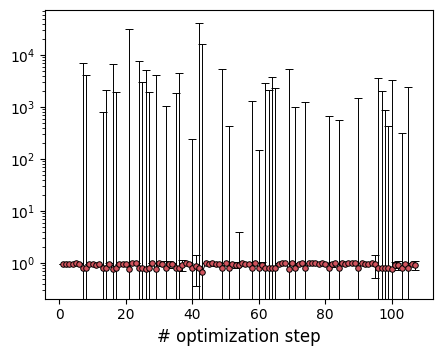

In [8]:
x = np.arange(1, len(pulse_fidelities) + 1)

fig, ax1 = plt.subplots(1, figsize=(WIDTH * 10 , WIDTH * 10 * 6/8))
ax1.errorbar(x, pulse_fidelities, yerr = pulse_fidelities_err, fmt='o',linestyle='none', 
             markersize=4, color="black", markerfacecolor=RED, ecolor="black", markeredgewidth=0.7, elinewidth=0.7, alpha=1, capsize=3)
ax1.plot(x, pulse_fidelities, '-', color='black', linewidth=0.7)
ax1.set_xlabel('# optimization step',  fontsize=12)
ax1.set_yscale('log')
plt.savefig('first_plot', bbox_inches="tight", dpi=600)

#controllare se l'incertezza è compatibile ed eventualmente coerente con la fidelity 


## Results analysis from optimization history

In this section the data analysis was carried out using data and information stored in the the output of the optimization routine.

This way we are ablo to retrive also the values of the optimized paramters for the optimization history.

Unfortunately no error was estimated runtime during optimization so no information is available for error.

In [9]:
loaded = np.load('optimization_history.npz')
iterations = loaded['iterations']
parameters = loaded['parameters']
objective_values = loaded['objective_values']
objective_values_error = loaded['objective_value_errors']

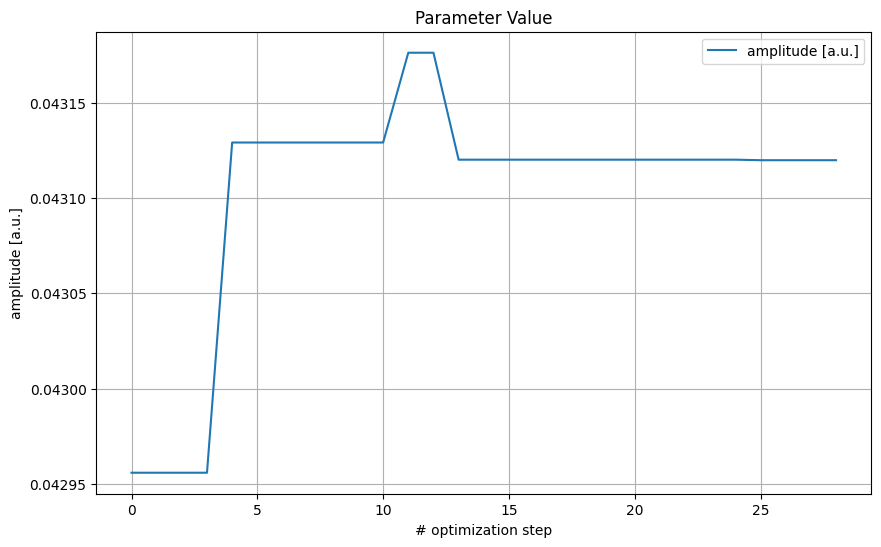

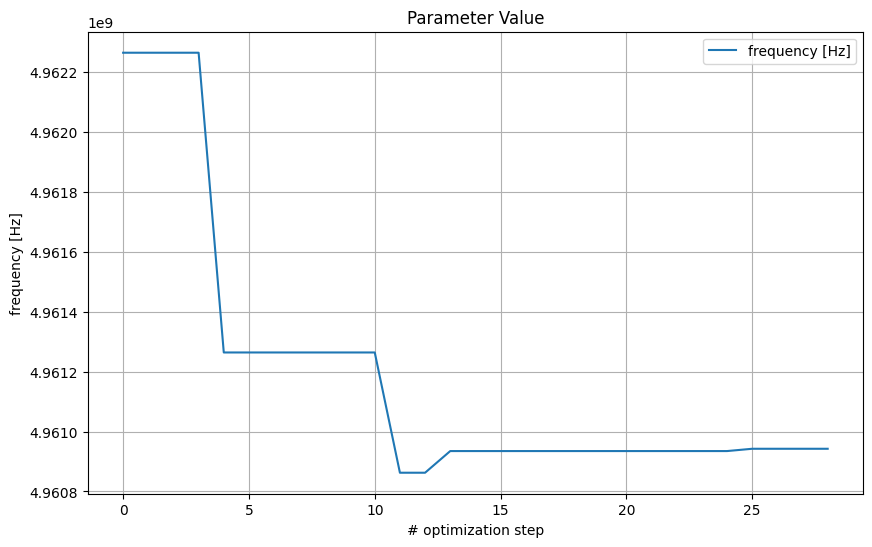

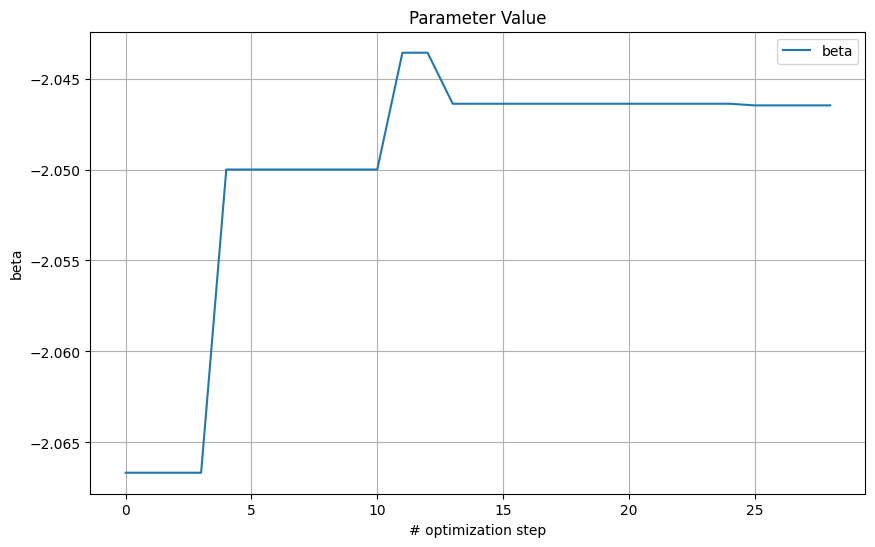

In [10]:
# Plot each parameter as a function of the iteration step
params_name = ['amplitude [a.u.]', 'frequency [Hz]', 'beta']

for i in range(parameters.shape[1]):
    plt.figure(figsize=(10, 6))  # Create a new figure for each parameter
    plt.plot(iterations, parameters[:, i], label=f'{params_name[i]}')
    plt.xlabel('# optimization step')
    plt.ylabel(f'{params_name[i]}')
    plt.title('Parameter Value')
    plt.legend()
    plt.grid()
    plt.show()

/tmp/ipykernel_22674/2575974903.py:8: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


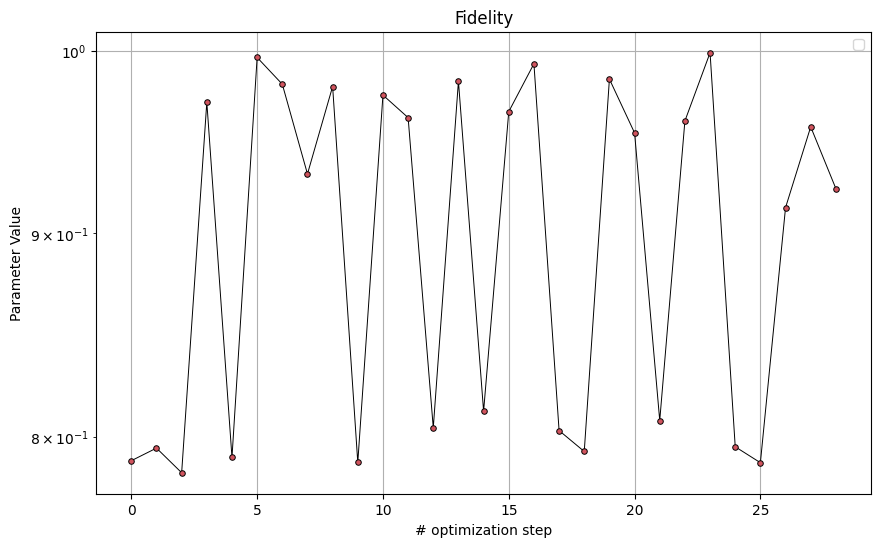

In [11]:
plt.figure(figsize=(10, 6))  # Create a new figure for each parameter
plt.plot(iterations, 1-objective_values, 'o-', markersize=4, color='black', 
         markerfacecolor=RED, markeredgewidth=0.7, linewidth=0.7, alpha=1)
plt.xlabel('# optimization step')
plt.ylabel('Parameter Value')
plt.yscale('log')
plt.title(f'Fidelity')
plt.legend()
plt.grid()
plt.show()

## Result object analysis

In this section I print and explore the results of the optimization cycle as standard output of the `scipy.minimize` method

In [12]:
import pickle

with open('optimization_result.pkl', 'rb') as file:
    result = pickle.load(file)

print(result)

       message: Maximum number of iterations has been exceeded.
       success: False
        status: 2
           fun: 0.0009060217715413248
             x: [ 4.312e-02  4.961e+09 -2.046e+00]
           nit: 30
          nfev: 78
 final_simplex: (array([[ 4.312e-02,  4.961e+09, -2.046e+00],
                       [ 4.312e-02,  4.961e+09, -2.046e+00],
                       [ 4.312e-02,  4.961e+09, -2.046e+00],
                       [ 4.312e-02,  4.961e+09, -2.046e+00]]), array([ 9.060e-04,  5.005e-02,  6.155e-02,  1.927e-01]))


Nota: l'ottimizzazione è stata eseguita in circa 1h (poco meno) partendo da un qubit non calibrato e utilizzando il metodo del simplesso